# Overview

This project aims to create a model to predict COVID-associated mortality using information available at the time of patient diagnosis.

The used database was provided by the Mexican government (https://www.kaggle.com/datasets/meirnizri/covid19-dataset). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

* sex: 1 for female and 2 for male.
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in differentdegrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
* patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.**

# Import libraries

In [2]:
import numpy as np 
import pandas as pd 
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Load data

In [3]:
df = pd.read_csv('/kaggle/input/covid19-dataset/Covid Data.csv')

# EDA and data cleaning

In [4]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [5]:
for column in df.columns:
    df[column] = df[column].replace([97, 98, 99], np.nan)

In [6]:
df.isna().sum()

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                        345
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64

In [7]:
df.describe().round(1)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,1048575.0,1048575.0,1048575.0,1048575.0,192706.0,1032572.0,1048230.0,521310.0,1045237.0,1045572.0,1045596.0,1045171.0,1045471.0,1043530.0,1045499.0,1045543.0,1045569.0,1045355.0,1048575.0,192543.0
mean,1.6,9.0,1.5,1.2,1.8,1.9,41.8,2.0,1.9,2.0,2.0,2.0,1.8,2.0,2.0,1.8,2.0,1.9,5.3,1.9
std,0.5,3.7,0.5,0.4,0.4,0.3,16.9,0.1,0.3,0.1,0.2,0.1,0.4,0.2,0.1,0.4,0.1,0.3,1.9,0.3
min,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,4.0,1.0,1.0,2.0,2.0,30.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0
50%,2.0,12.0,1.0,1.0,2.0,2.0,40.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,6.0,2.0
75%,2.0,12.0,2.0,1.0,2.0,2.0,53.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7.0,2.0
max,2.0,13.0,2.0,2.0,2.0,2.0,121.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7.0,2.0


In [8]:
df['USMER'].nunique()

2

In [9]:
#This remaps the dataframe to a more conventional format, where 0 means NO and 1 means YES. 
#For sex, this means 0 for female, 1 for male.
#For PATIENT_TYPE, this means 0 for returned home, 1 for hospitalization.
GLOBAL_remap = {1: 1, 2: 0}

columns_to_remap = ['SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'CLASIFFICATION_FINAL', 'ICU', 'INTUBED', 'INMSUPR', 'TOBACCO']

df[columns_to_remap] = df[columns_to_remap].map(GLOBAL_remap.get)

In [10]:
df.describe().round(1)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,1048575.0,1048575.0,1048575.0,1048575.0,192706.0,1032572.0,1048230.0,521310.0,1045237.0,1045572.0,1045596.0,1045171.0,1045471.0,1043530.0,1045499.0,1045543.0,1045569.0,1045355.0,10452.0,192543.0
mean,1.6,9.0,0.5,0.8,0.2,0.1,41.8,0.0,0.1,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.1,0.8,0.1
std,0.5,3.7,0.5,0.4,0.4,0.3,16.9,0.1,0.3,0.1,0.2,0.1,0.4,0.2,0.1,0.4,0.1,0.3,0.4,0.3
min,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,4.0,0.0,1.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50%,2.0,12.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75%,2.0,12.0,1.0,1.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
max,2.0,13.0,1.0,1.0,1.0,1.0,121.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
#create a new bool variable for whether the patient survived (0) or died (1)

df['NO_SURV'] = df['DATE_DIED']

# Iterate through the 'DATE_DIED' column
for i, value in enumerate(df['NO_SURV']):
    if value == '9999-99-99':
        df.at[i, 'NO_SURV'] = 0
    else:
        df.at[i, 'NO_SURV'] = 1

# Convert the 'DATE_DIED' column to numeric type
df['NO_SURV'] = pd.to_numeric(df['NO_SURV'], errors='coerce')

In [12]:
print(df['NO_SURV'].value_counts())
print(df['PNEUMONIA'].value_counts())
print(df.isna().sum())

NO_SURV
0    971633
1     76942
Name: count, dtype: int64
PNEUMONIA
0.0    892534
1.0    140038
Name: count, dtype: int64
USMER                         0
MEDICAL_UNIT                  0
SEX                           0
PATIENT_TYPE                  0
DATE_DIED                     0
INTUBED                  855869
PNEUMONIA                 16003
AGE                         345
PREGNANT                 527265
DIABETES                   3338
COPD                       3003
ASTHMA                     2979
INMSUPR                    3404
HIPERTENSION               3104
OTHER_DISEASE              5045
CARDIOVASCULAR             3076
OBESITY                    3032
RENAL_CHRONIC              3006
TOBACCO                    3220
CLASIFFICATION_FINAL    1038123
ICU                      856032
NO_SURV                       0
dtype: int64


In [13]:
df2 = df.copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   USMER                 1048575 non-null  int64  
 1   MEDICAL_UNIT          1048575 non-null  int64  
 2   SEX                   1048575 non-null  int64  
 3   PATIENT_TYPE          1048575 non-null  int64  
 4   DATE_DIED             1048575 non-null  object 
 5   INTUBED               192706 non-null   float64
 6   PNEUMONIA             1032572 non-null  float64
 7   AGE                   1048230 non-null  float64
 8   PREGNANT              521310 non-null   float64
 9   DIABETES              1045237 non-null  float64
 10  COPD                  1045572 non-null  float64
 11  ASTHMA                1045596 non-null  float64
 12  INMSUPR               1045171 non-null  float64
 13  HIPERTENSION          1045471 non-null  float64
 14  OTHER_DISEASE         1043530 non-

In [14]:
#we will assume that these parameters are negative in case of missing data. It's highly unlikely that an intubation procedure would not be reported
df2['INTUBED'] = df2['INTUBED'].fillna(0)
df2['PNEUMONIA'] = df2['PNEUMONIA'].fillna(0)
df2['PREGNANT'] = df2['PREGNANT'].fillna(0)
df2['INTUBED']= df2['INTUBED'].fillna(0)
df2['ICU']= df2['ICU'].fillna(0)

#Dropping "clasiffication_final", as it barely has any values and there is no meaning attached to the variable
df2.drop('CLASIFFICATION_FINAL', axis=1, inplace=True)

In [15]:
missing_percentage = df2.isnull().mean() * 100

death_percentage = df2['NO_SURV'].mean() * 100
print(missing_percentage)
print(death_percentage)

USMER             0.000000
MEDICAL_UNIT      0.000000
SEX               0.000000
PATIENT_TYPE      0.000000
DATE_DIED         0.000000
INTUBED           0.000000
PNEUMONIA         0.000000
AGE               0.032902
PREGNANT          0.000000
DIABETES          0.318337
COPD              0.286389
ASTHMA            0.284100
INMSUPR           0.324631
HIPERTENSION      0.296021
OTHER_DISEASE     0.481129
CARDIOVASCULAR    0.293350
OBESITY           0.289154
RENAL_CHRONIC     0.286675
TOBACCO           0.307083
ICU               0.000000
NO_SURV           0.000000
dtype: float64
7.337767923133777


In [16]:
#All other missing values for each category are well below 1% of the total dataset, so I'll remove them

df2.dropna(inplace=True)

In [17]:
Total_features = ['USMER','MEDICAL_UNIT', 'SEX','PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU', 'NO_SURV']
#REMOVED ICU/INTUBATION events, we intend to use only information present at the time of hospital admission
used_features = ['SEX', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']

#used_features = ['USMER','MEDICAL_UNIT', 'SEX','PATIENT_TYPE', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO','ICU', 'INTUBED']

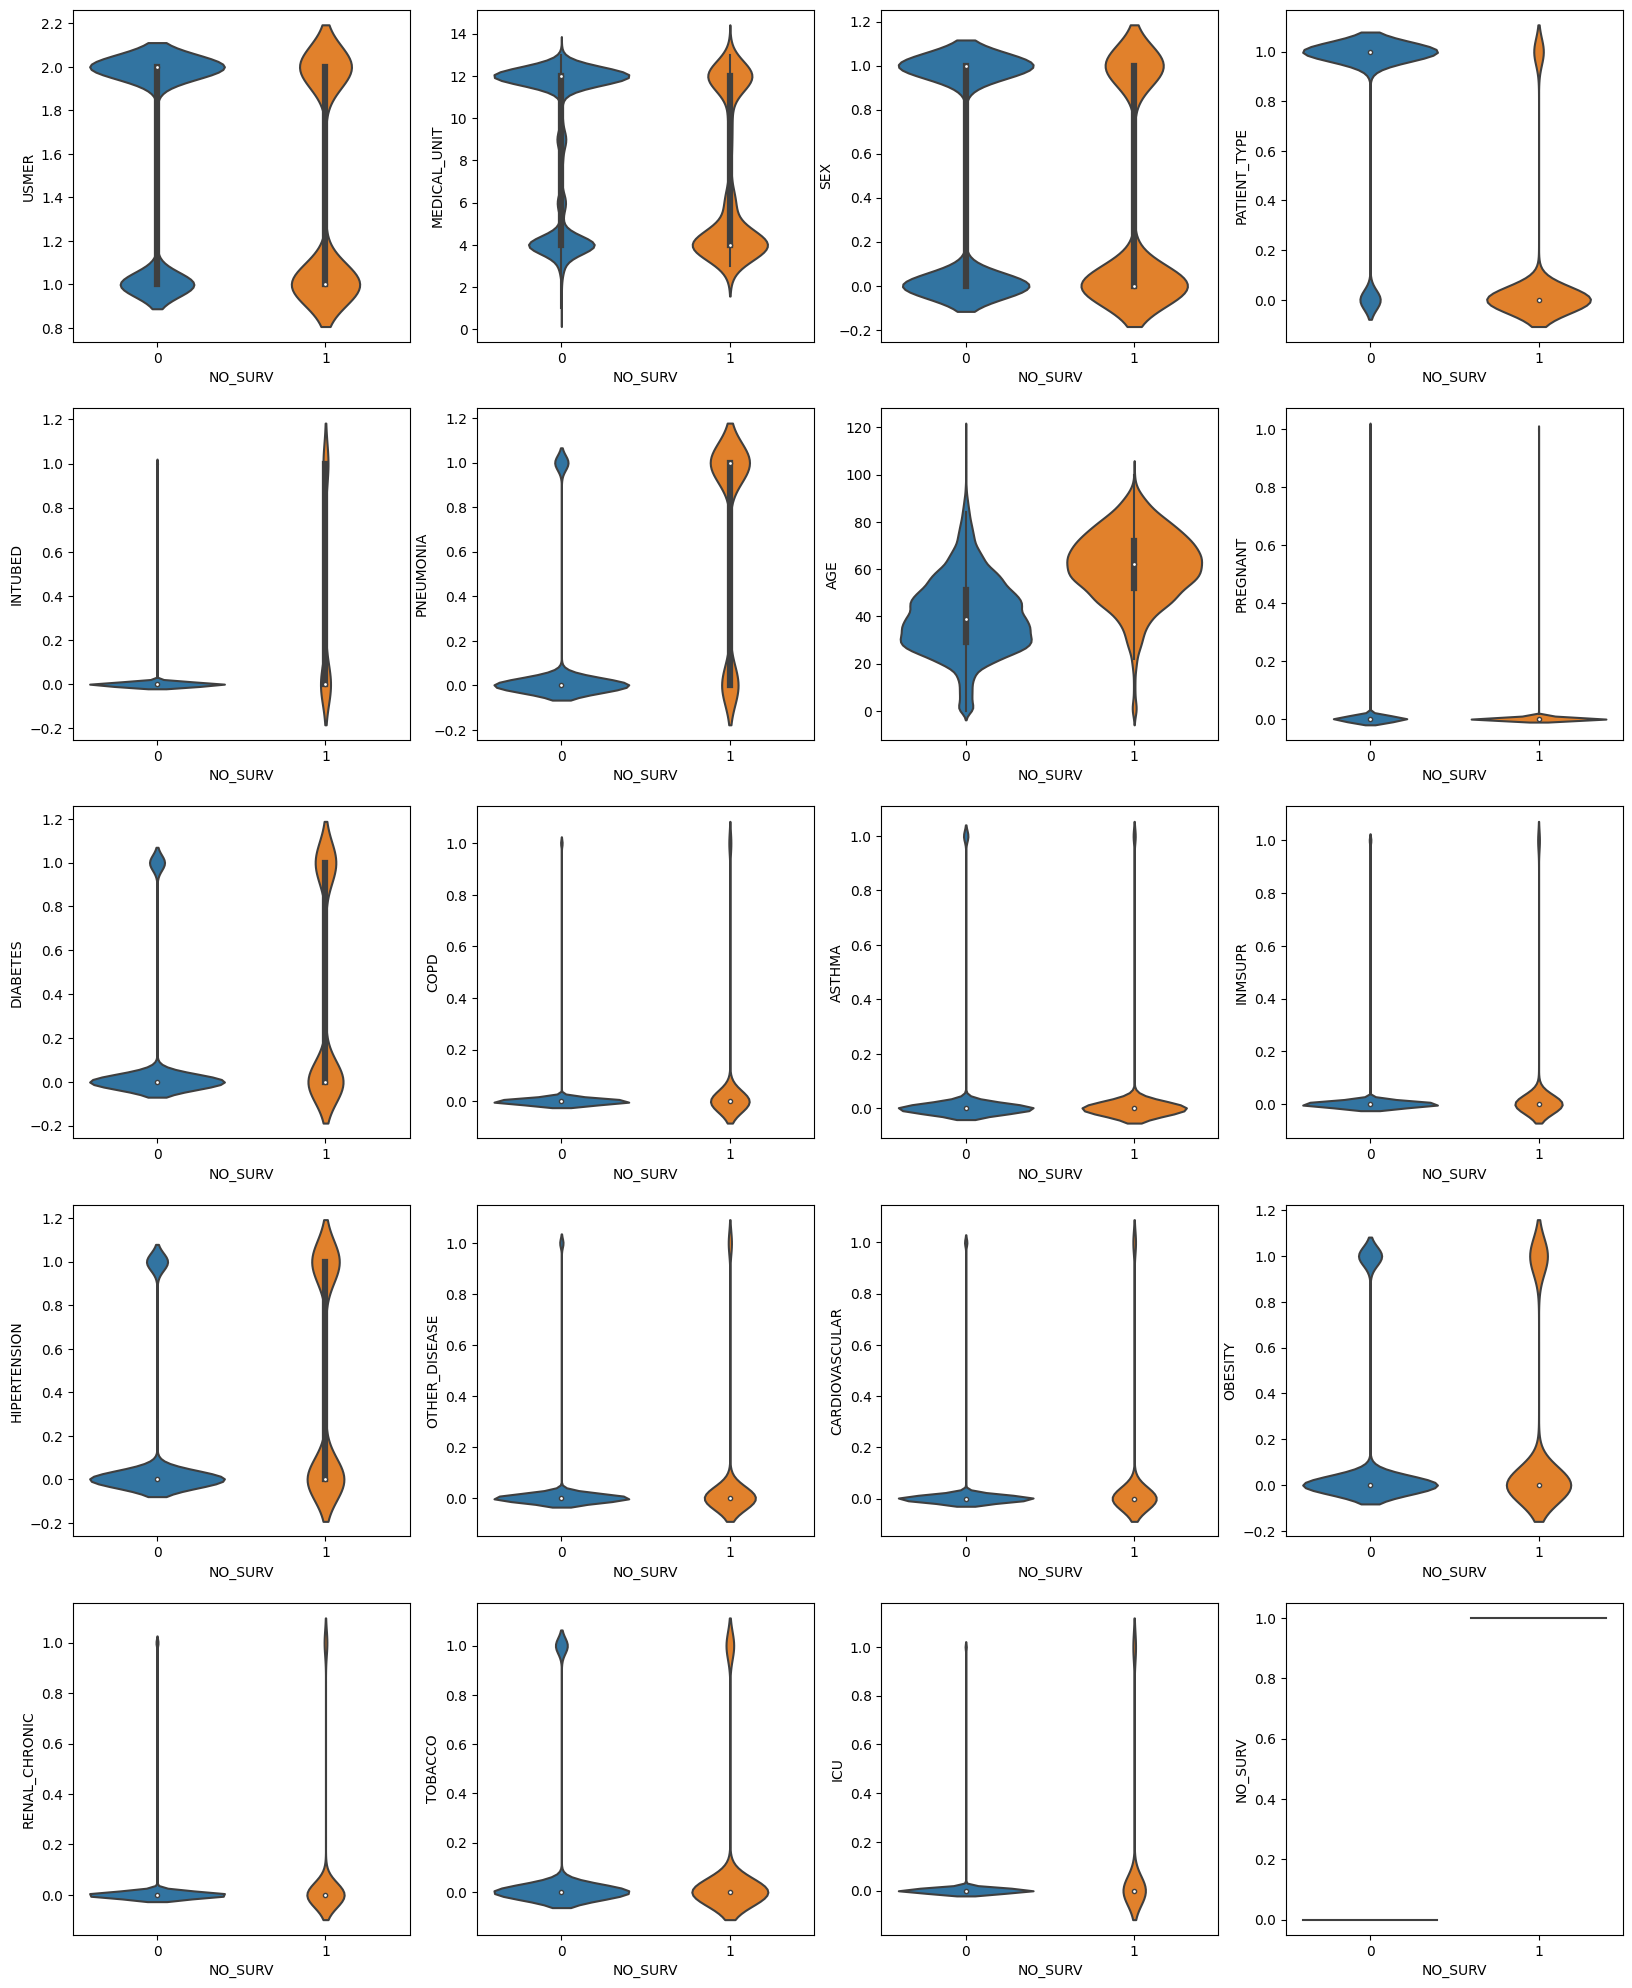

In [18]:
plt.figure(figsize=(20,25))
i = 0

for egg in Total_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.violinplot(x='NO_SURV', y=egg, data=df2.sample(50000))

plt.show()

In [19]:
#check how much of the original dataset is kept after removing missing values
pc_of_org = len(df2['USMER'])/len(df['USMER'])*100
print(f"{pc_of_org:.2f}% of original data entries have been kept")

99.25% of original data entries have been kept


In [20]:
variables_to_int = ['MEDICAL_UNIT', 'SEX', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU', 'NO_SURV']
df2[variables_to_int] = df2[variables_to_int].astype('int')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1040674 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   USMER           1040674 non-null  int64 
 1   MEDICAL_UNIT    1040674 non-null  int64 
 2   SEX             1040674 non-null  int64 
 3   PATIENT_TYPE    1040674 non-null  int64 
 4   DATE_DIED       1040674 non-null  object
 5   INTUBED         1040674 non-null  int64 
 6   PNEUMONIA       1040674 non-null  int64 
 7   AGE             1040674 non-null  int64 
 8   PREGNANT        1040674 non-null  int64 
 9   DIABETES        1040674 non-null  int64 
 10  COPD            1040674 non-null  int64 
 11  ASTHMA          1040674 non-null  int64 
 12  INMSUPR         1040674 non-null  int64 
 13  HIPERTENSION    1040674 non-null  int64 
 14  OTHER_DISEASE   1040674 non-null  int64 
 15  CARDIOVASCULAR  1040674 non-null  int64 
 16  OBESITY         1040674 non-null  int64 
 17  RENAL_CHRONIC

In [21]:
# Split the data into training and testing sets
X = df2[used_features].values
y= df2['NO_SURV']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
print(X.shape)
print(y.shape)

(1040674, 14)
(1040674,)


# Training and inference

In [23]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'early_stopping_rounds':10
}

# Train the model with early stopping
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_binary))
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

[LightGBM] [Info] Number of positive: 60251, number of negative: 772288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 832539, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072370 -> initscore=-2.550838
[LightGBM] [Info] Start training from score -2.550838
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.156094
Accuracy: 0.9334806736012684
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96    193072
           1       0.57      0.33      0.42     15063

    accuracy                           0.93    208135
   macro avg       0

In [25]:
ft_imp= bst.feature_importance()
my_dict = dict(zip(used_features, ft_imp))
df_stats = pd.DataFrame(list(my_dict.items()), columns=['Features', 'Feature Importance'])
df_stats.sort_values(by='Feature Importance', ascending=False, inplace=True)
df_stats.head()

,Features,Feature Importance
2,AGE,807
0,SEX,367
12,RENAL_CHRONIC,289
9,OTHER_DISEASE,267
4,DIABETES,262


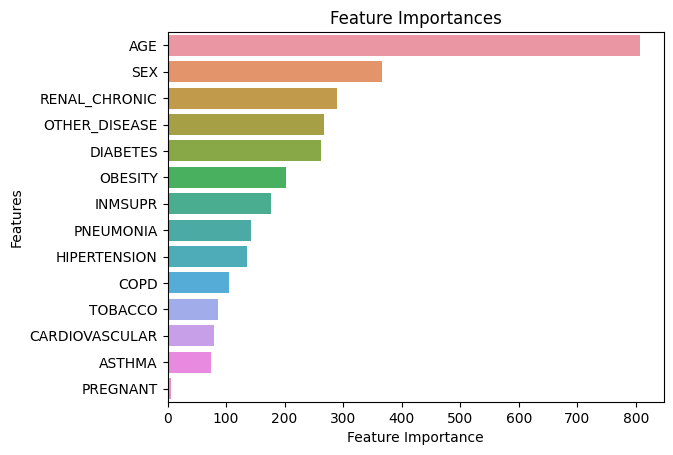

In [27]:
sns.barplot(x='Feature Importance', y='Features', data=df_stats)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

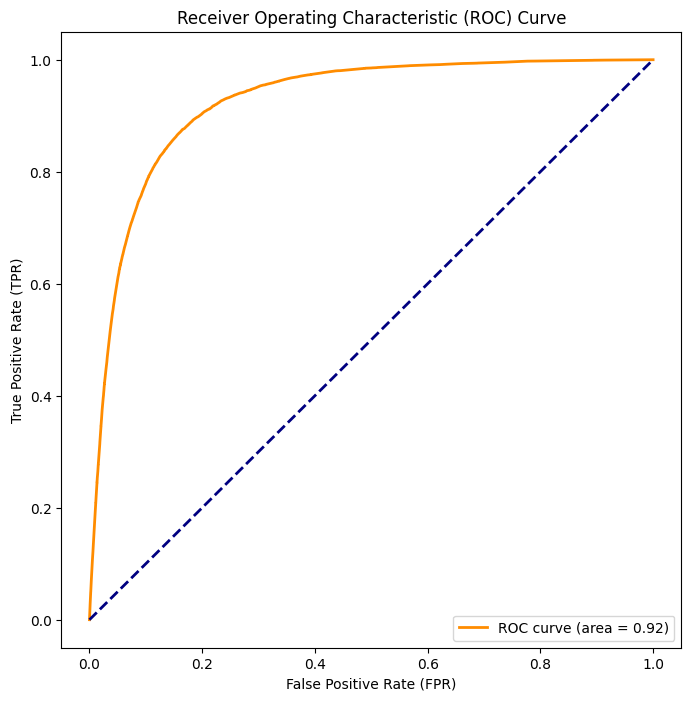

In [28]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [29]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9242472070262001


# Conclusion

Considering solely accuracy as the only metric for the model's performance, we can see that a LGB model with just a couple of non-informative features performs very well... Accuracy > 0.90. However, this is due to the imbalanced nature of the dataset. Since there is a roughly 9:1 ratio of survived vs dead patients, a model that randomly assigns 0/1 classifications in a 9:1 ratio would perform very well. However, when such a model is analysed with a receiver operating characteristic (ROC) analysis, one can clearly see that its AUC is close to 0.5 (i.e. completely random).

On the other hand, building a model with most available likely non-leaky features (available at the time of patient admission) yields a model with high accuracy and high ROC. In this last example accuracy is aprox 0.933 and AUC 0.924.